In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Зональна статистика для секторів IMI
 – усі маси за реальну тривалість відповідного вікна інверсії (59 або 61 діб)
"""

# ────────────────────── імпорти ────────────────────────────────────────────
from pathlib import Path
import yaml, xarray as xr, numpy as np, pandas as pd
import geopandas as gpd, regionmask
import matplotlib.pyplot as plt, matplotlib.patheffects as pe

# ────────────────────── шляхи / константи ─────────────────────────────────
BASE     = Path("/home/hermit/imi_output_dir")
PERIODS  = ["PreWar_SepOct2021", "WarOnset_FebMar2022",
            "WarOnset_MayJun2022", "War_FebMar2023", "War_JunJul2023"]
SECTORS  = ["Oil","Gas","Coal","Livestock","Landfills","Reservoirs"]

# скільки діб охоплює кожна інверсія
DAYS_PER_PERIOD = {
    "PreWar_SepOct2021": 61,
    "WarOnset_FebMar2022": 59,
    "WarOnset_MayJun2022": 61,
    "War_FebMar2023":    59,
    "War_JunJul2023":    61,
}

S_PER_DAY  = 86_400
TG_PER_KG  = 1e-9
THR_PCT    = 0.00001         # поріг для %-карти (kt)

# ────────────────────── shapefile → regionmask ────────────────────────────
GDF_OBL  = gpd.read_file("regions.shp").to_crs(4326)
OBL_MASK = regionmask.Regions(GDF_OBL.geometry.values,
                              names=GDF_OBL["TITLE"].tolist(),
                              name="UA_oblasts")

# ────────────────────── 1. Tg/period по областях ──────────────────────────
def tg_per_setup(setup_dir: Path, sector: str, days: int) -> pd.Series:
    """Tg за «days» діб для кожної області + total."""
    # nBufferClusters
    with open(setup_dir / f"config_{setup_dir.name}.yml") as f:
        nbuf = int(yaml.safe_load(f).get("nBufferClusters", 0))

    ds   = xr.open_dataset(setup_dir / "inversion/output/netCDF/posterior.nc")
    flux = ds[f"EmisCH4_{sector}"]              # kg m⁻² s⁻¹
    if "time" in flux.dims:
        flux = flux.mean("time")
    area = ds["AREA"]

    sv   = xr.open_dataset(setup_dir / "StateVector.nc")["StateVector"]
    roi  = sv <= (int(np.nanmax(sv)) - nbuf)

    tg_grid = flux * area * roi * S_PER_DAY * days * TG_PER_KG   # Tg/period

    sums = tg_grid.groupby(OBL_MASK.mask(tg_grid)).sum()
    data = {name: float(sums.sel(mask=i)) if i in sums["mask"] else 0.0
            for i, name in enumerate(OBL_MASK.names)}
    data["UA_total_Tg"] = float(tg_grid.sum())
    return pd.Series(data)

# ────────────────────── 2. таблиця (rows=period) ──────────────────────────
def build_df(sector: str) -> pd.DataFrame:
    rows = []
    outdir = Path("tables/zonal_stats") / sector
    outdir.mkdir(parents=True, exist_ok=True)

    for tag in PERIODS:
        days = DAYS_PER_PERIOD[tag]
        short = tag.split('_',1)[1]           # «SepOct2021» тощо
        rows.append(tg_per_setup(BASE/tag, sector, days)
                    .rename(short).to_frame().T)

    df = pd.concat(rows)
    data = df.copy() * 1000
    data.to_csv(outdir / f"{sector}_all_kt_periods.csv", index_label="period")
    df.to_csv(outdir / f"{sector}_all_tg_periods.csv", index_label="period")
    return df

# ────────────────────── 3. карти ──────────────────────────────────────────
def plot_3maps(df: pd.DataFrame, sector: str,
               p_old: str, p_new: str, thr=THR_PCT):

    # перестраховка: UA_total_Tg може бути або є, або ні
    cols = [c for c in df.columns if c != "UA_total_Tg"]
    gdf  = GDF_OBL.set_index("TITLE").loc[cols].copy()

    gdf["kt_old"] = df.loc[p_old, cols] * 1_000   # kt/period
    gdf["kt_new"] = df.loc[p_new, cols] * 1_000
    gdf["dk"]  = gdf["kt_new"] - gdf["kt_old"]
    with np.errstate(divide="ignore"):
        gdf["pct"] = 100 * gdf["dk"] / gdf["kt_old"]
    gdf.loc[gdf["kt_old"].abs() < thr, "pct"] = np.nan

    fig, axes = plt.subplots(2,2, figsize=(15,10))
    fig.subplots_adjust(wspace=.05, hspace=.15, bottom=.10, top=.92)
    axes = axes.flatten()

    gdf.plot("kt_old", cmap="turbo", scheme="NaturalBreaks", k=6,
             legend=True, legend_kwds={"title":"kt CH₄ / period"},
             edgecolor="k", linewidth=.5, ax=axes[0])
    axes[0].set_title(f"{sector} — {p_old}"); axes[0].axis("off")

    gdf.plot("kt_new", cmap="turbo", scheme="NaturalBreaks", k=6,
             legend=True, legend_kwds={"title":"kt CH₄ / period"},
             edgecolor="k", linewidth=.5, ax=axes[1])
    axes[1].set_title(f"{sector} — {p_new}"); axes[1].axis("off")

    vmax = gdf["dk"].abs().max()
    gdf.plot("dk", cmap="PRGn", vmin=-vmax, vmax=vmax,
             legend=True, legend_kwds={"label":"Δ kt"},
             edgecolor="k", linewidth=.5, ax=axes[2])
    axes[2].set_title(f"Δ {sector} ({p_old} → {p_new})"); axes[2].axis("off")

    vmax = gdf["pct"].abs().max()
    gdf.plot("pct", cmap="RdBu_r", vmin=-vmax, vmax=vmax,
             legend=True, legend_kwds={"label":"% зміна"},
             missing_kwds={"color":"lightgrey","edgecolor":"k",
                           "label":f"base < {thr} kt"},
             edgecolor="k", linewidth=.5, ax=axes[3])
    for _, r in gdf.iterrows():
        if not np.isnan(r["pct"]):
            x,y = r.geometry.centroid.coords[0]
            axes[3].text(x,y,f"{r['pct']:.0f}%",ha="center",va="center",
                         fontsize=7,color="black",
                         path_effects=[pe.withStroke(linewidth=1.3,
                                                     foreground="white")])
    axes[3].set_title(f"% зміна {sector} ({p_old} → {p_new})")
    axes[3].axis("off")

#     fig.suptitle(f"{sector} CH₄ (kt / period)\n{p_new} vs {p_old}",
#                  fontsize=14, y=.98)

    outdir = Path("images/zonal_stats")/sector
    outdir.mkdir(parents=True, exist_ok=True)
    fig.savefig(outdir/f"{sector}_{p_old}_vs_{p_new}.png",
                dpi=200, bbox_inches="tight")
    plt.show()

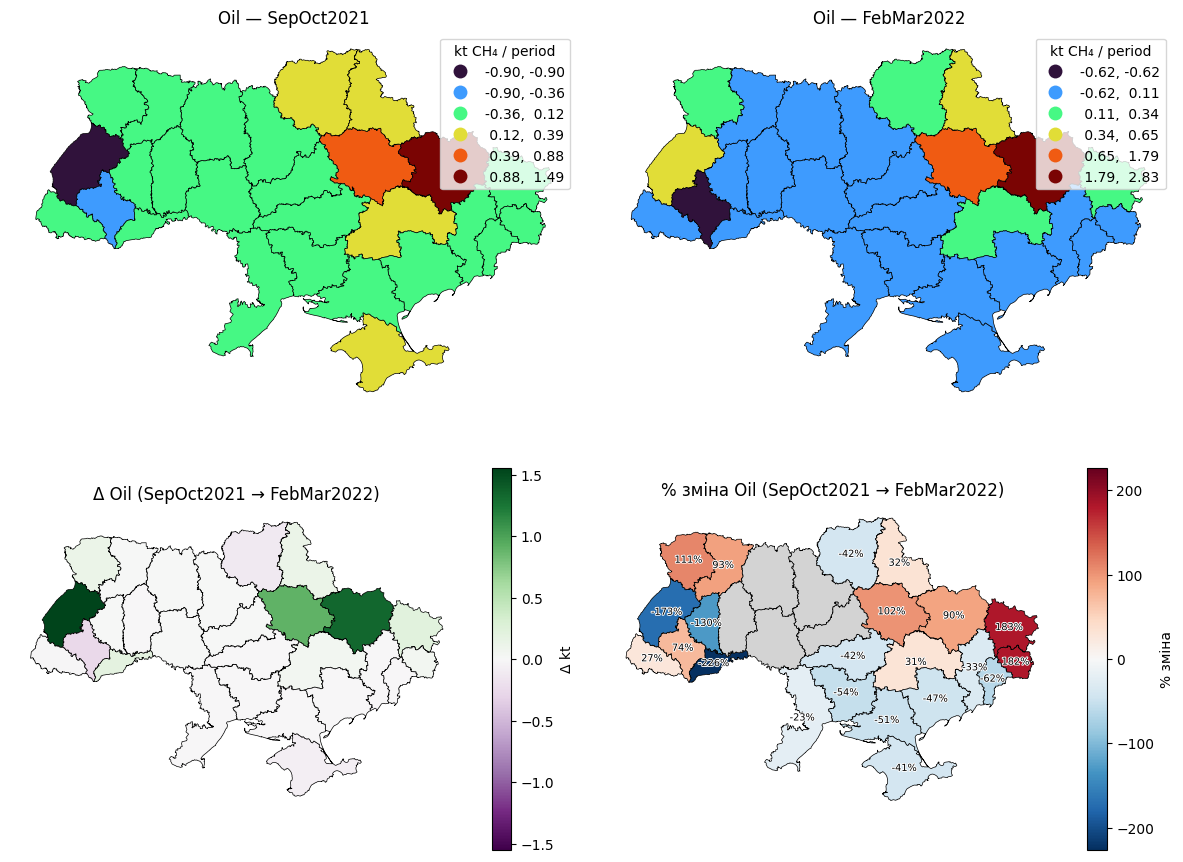

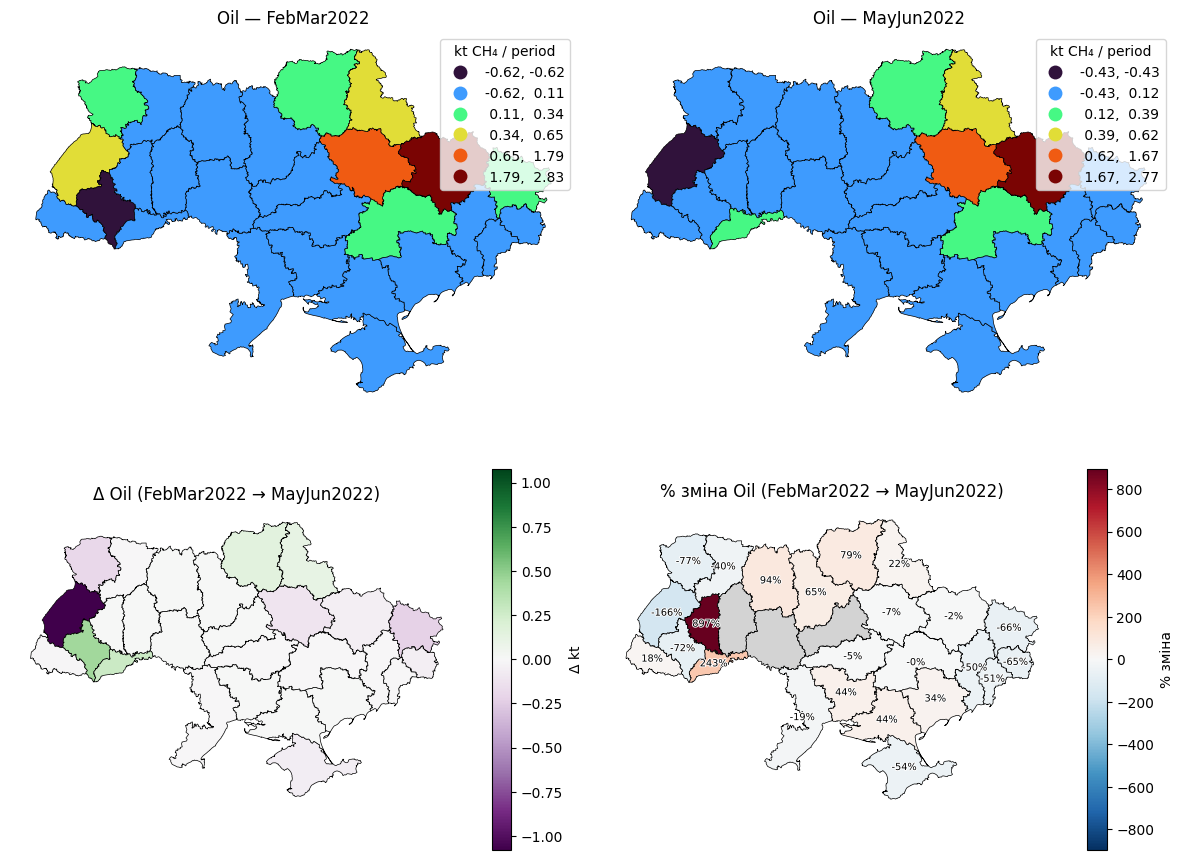

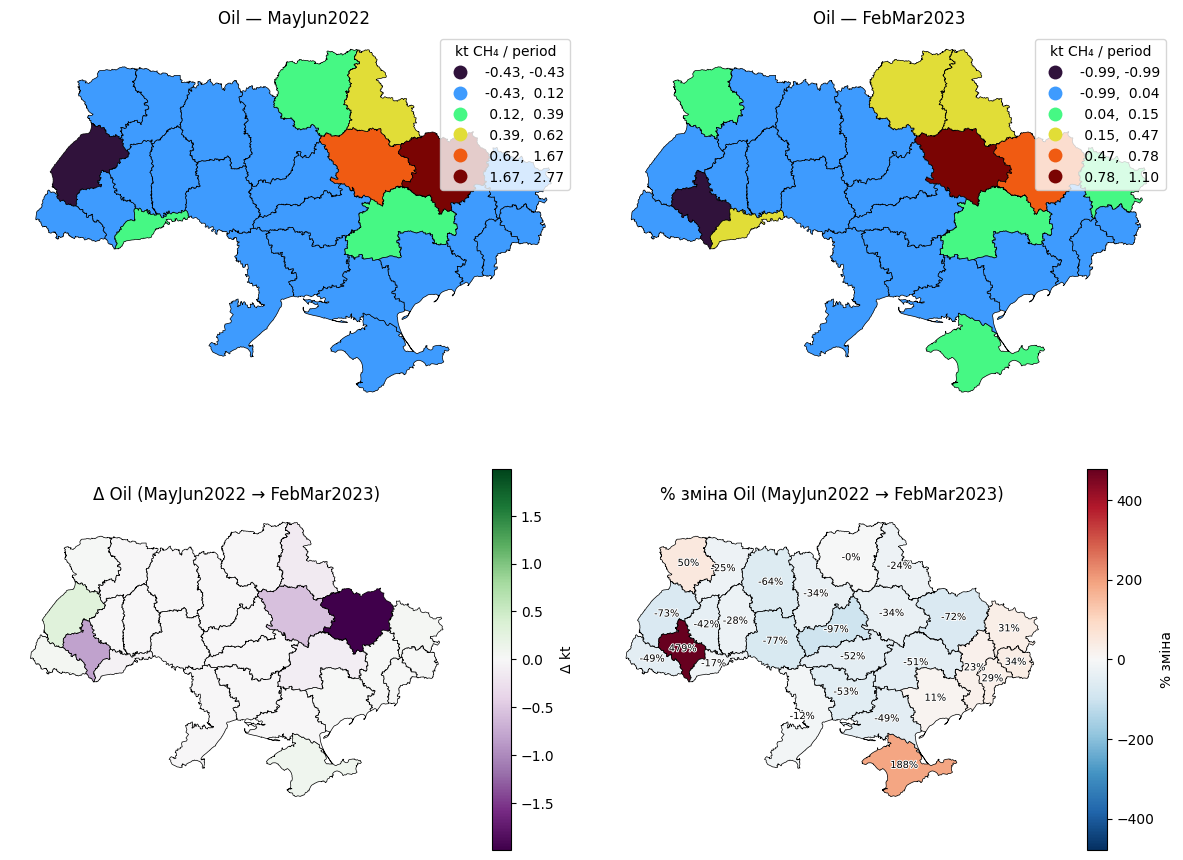

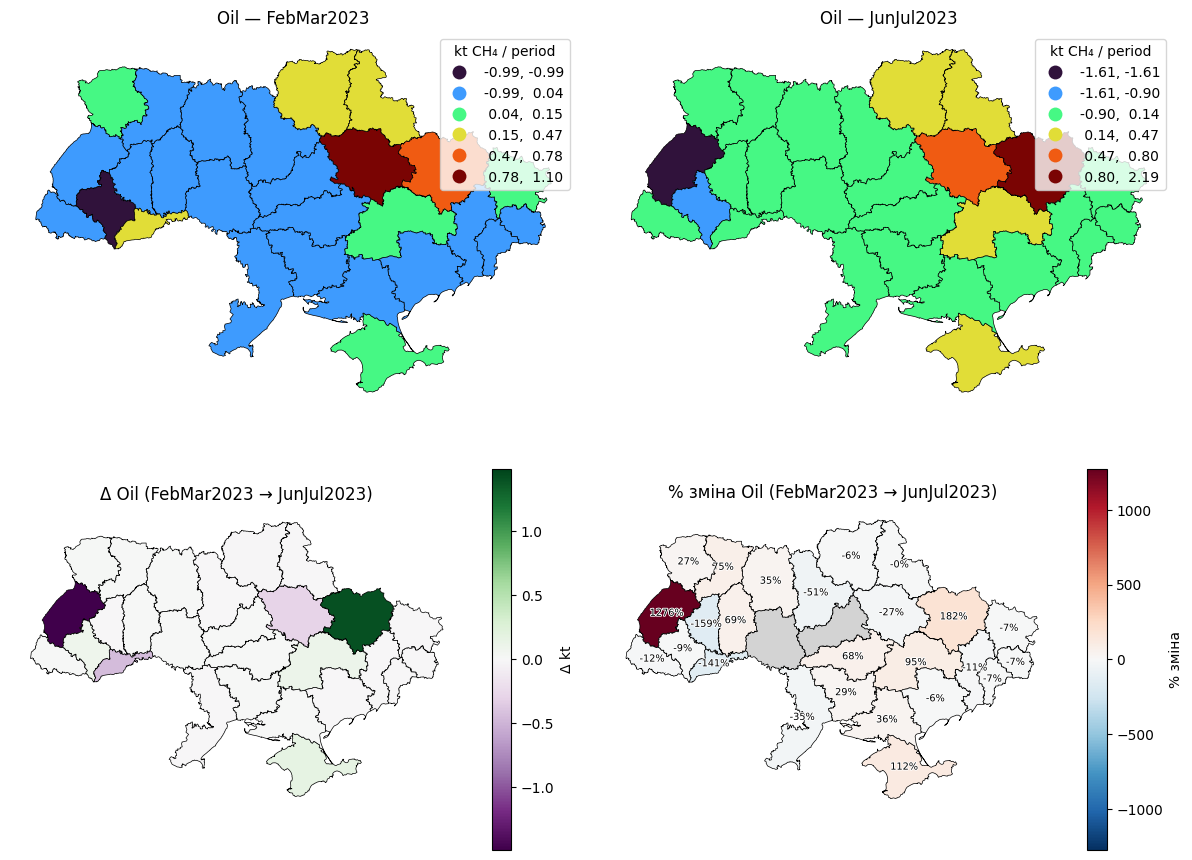

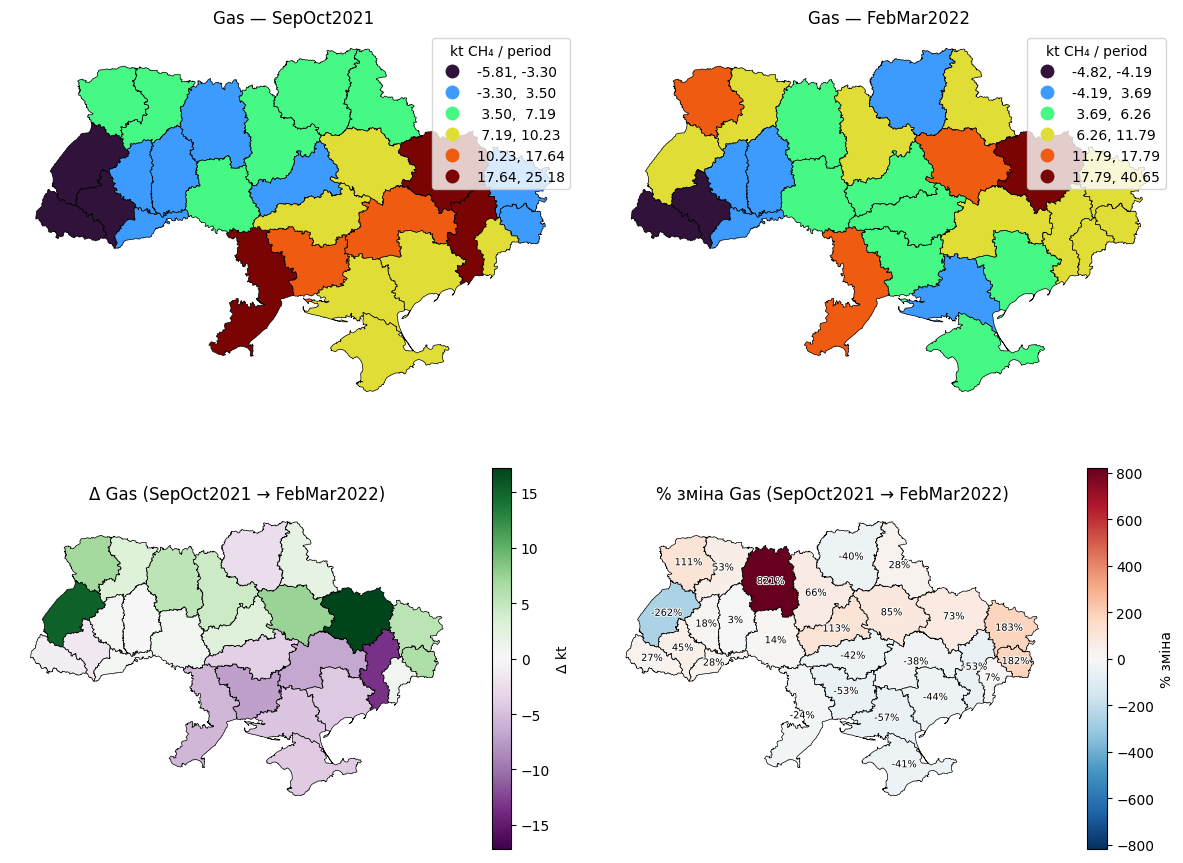

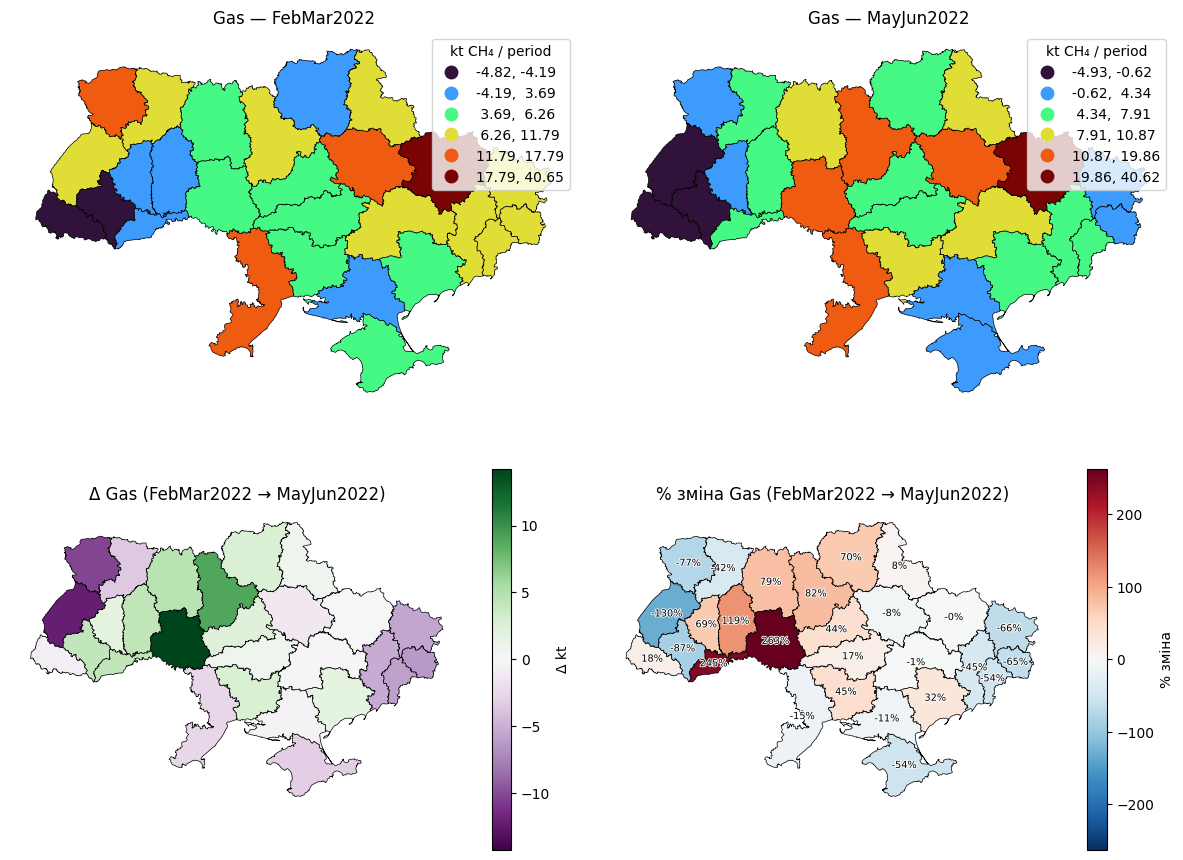

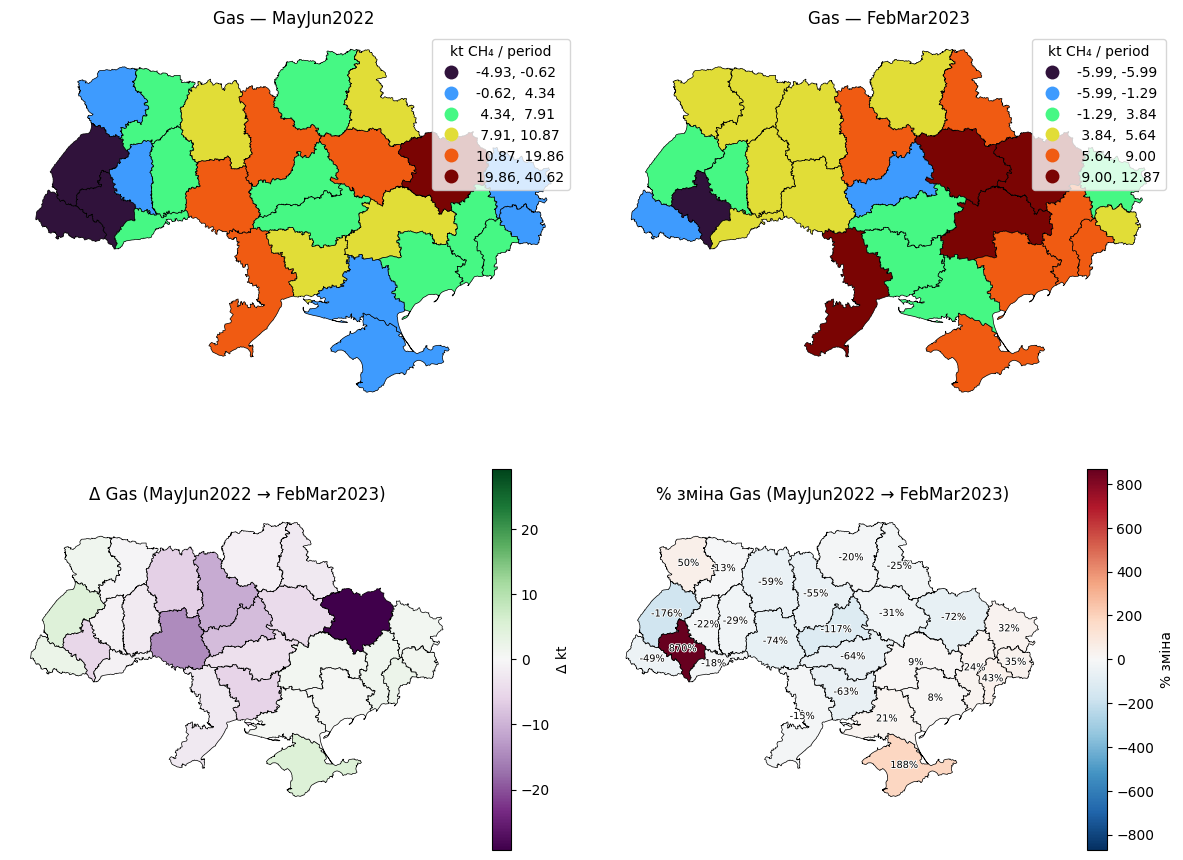

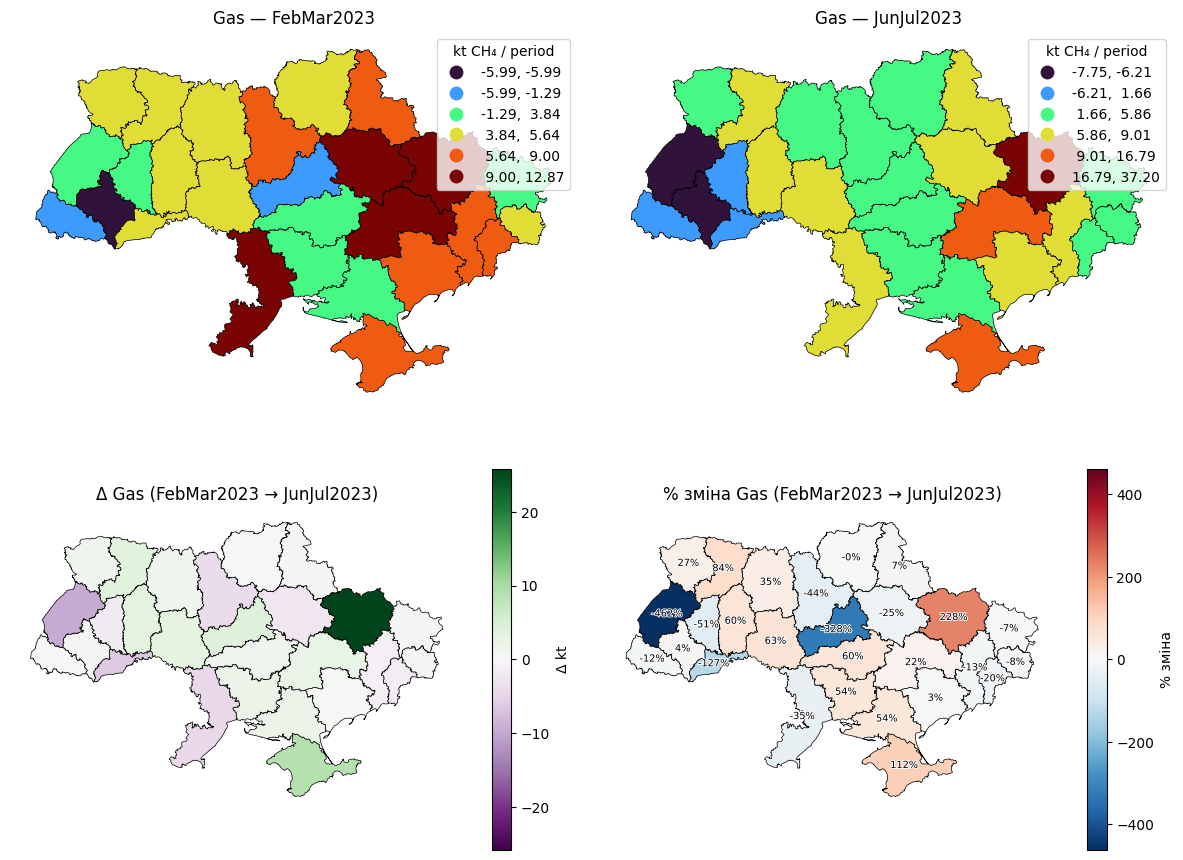

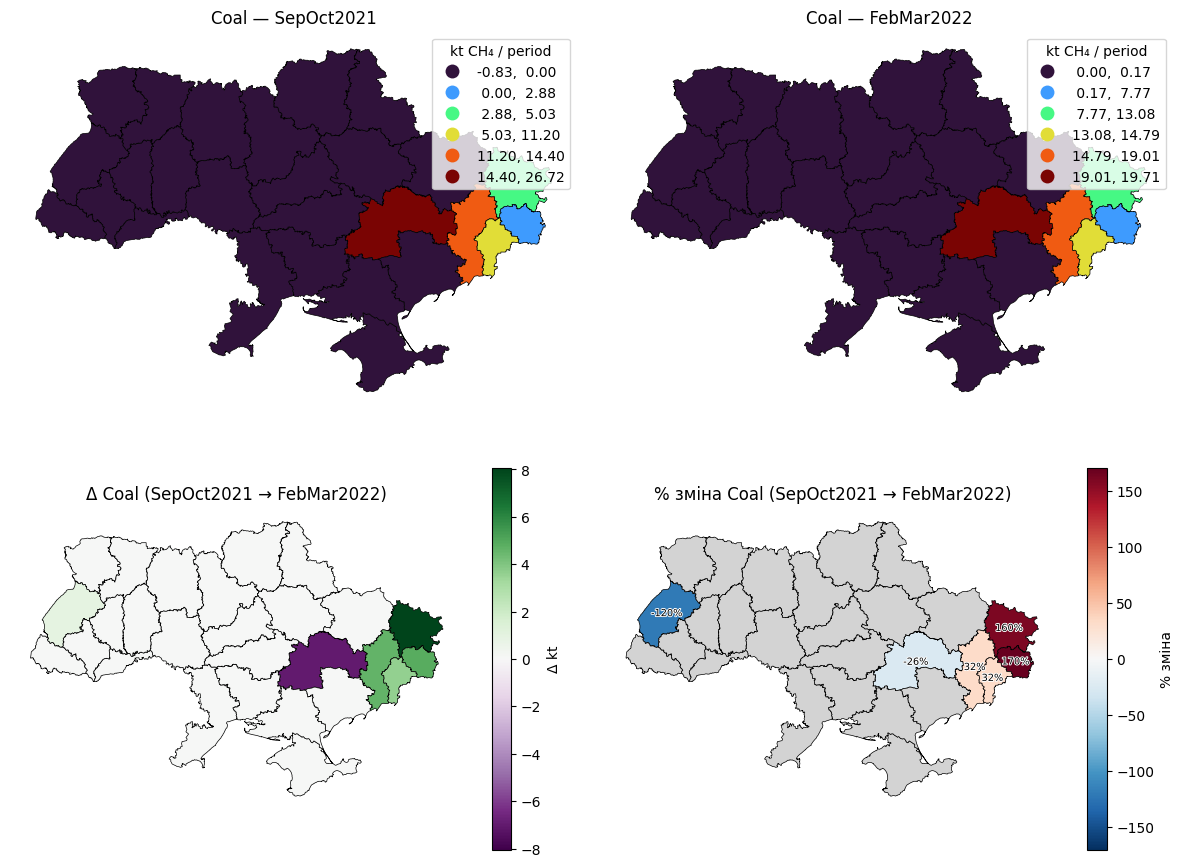

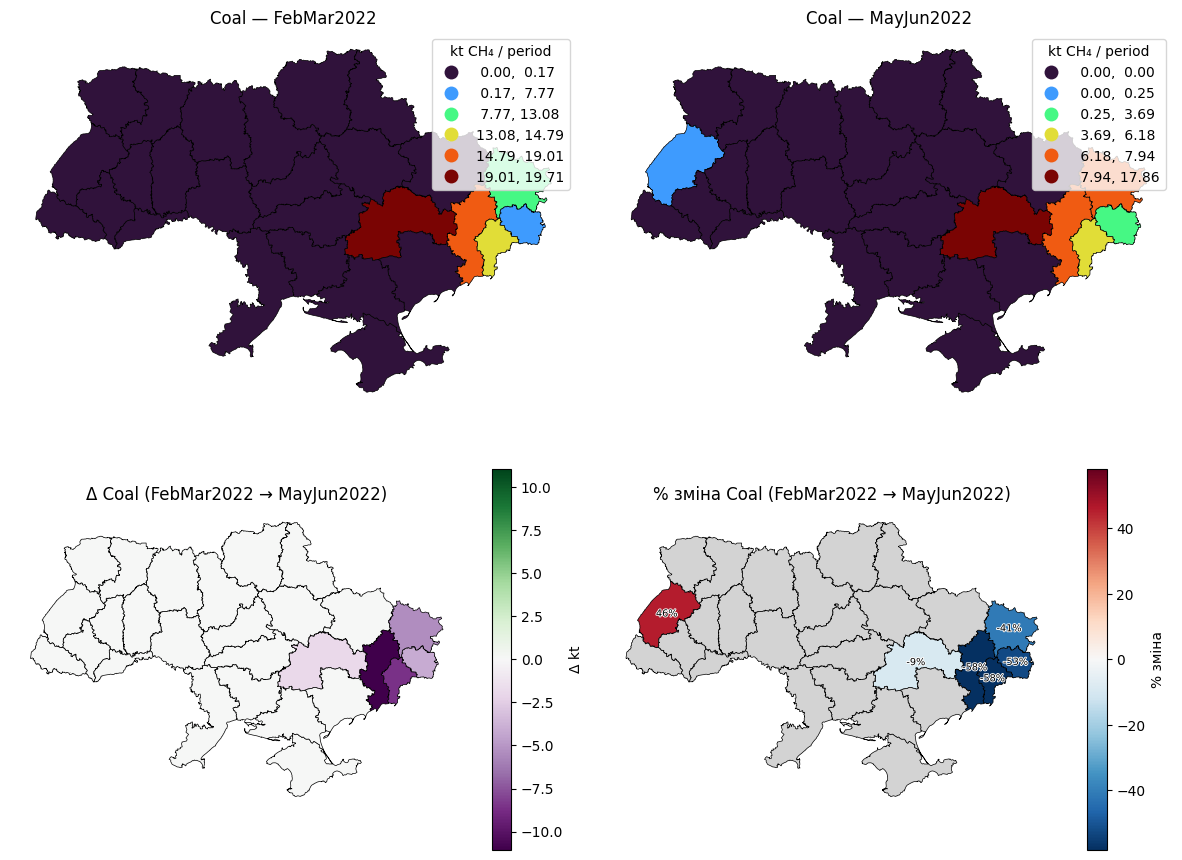

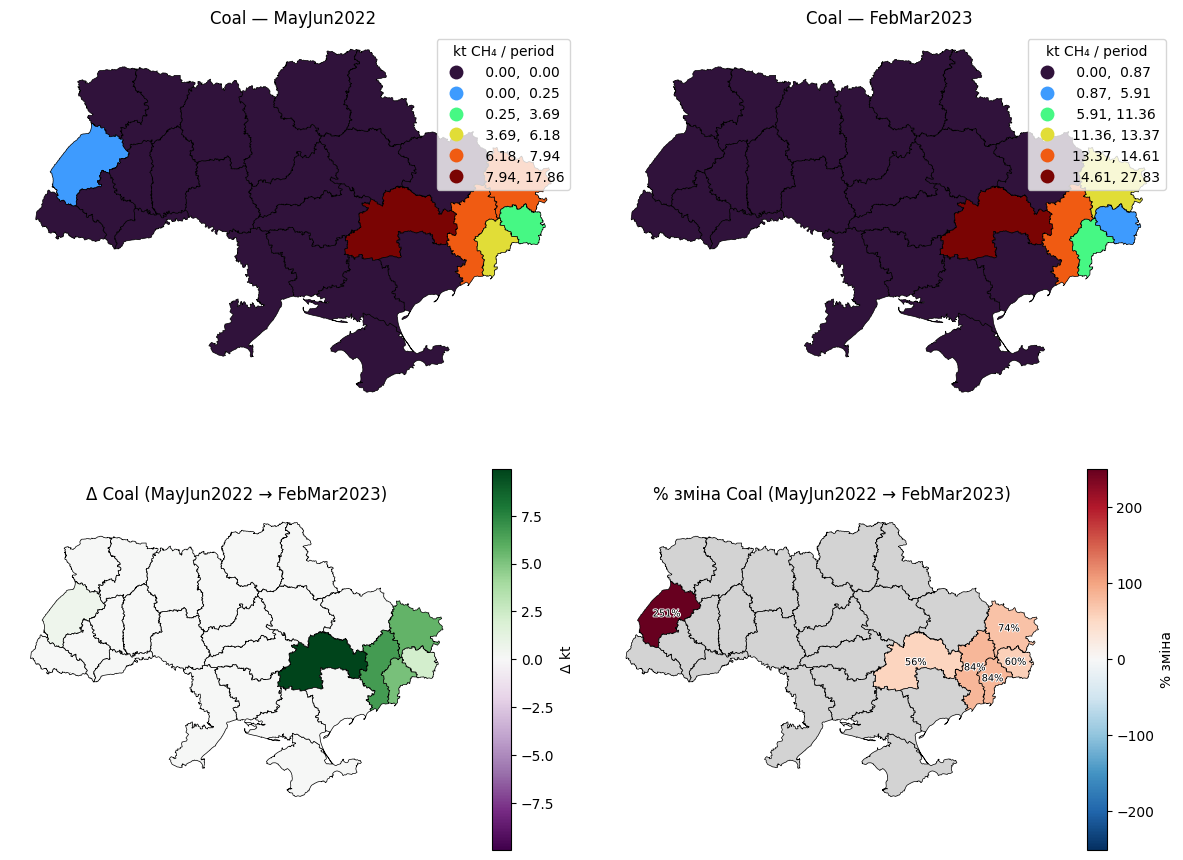

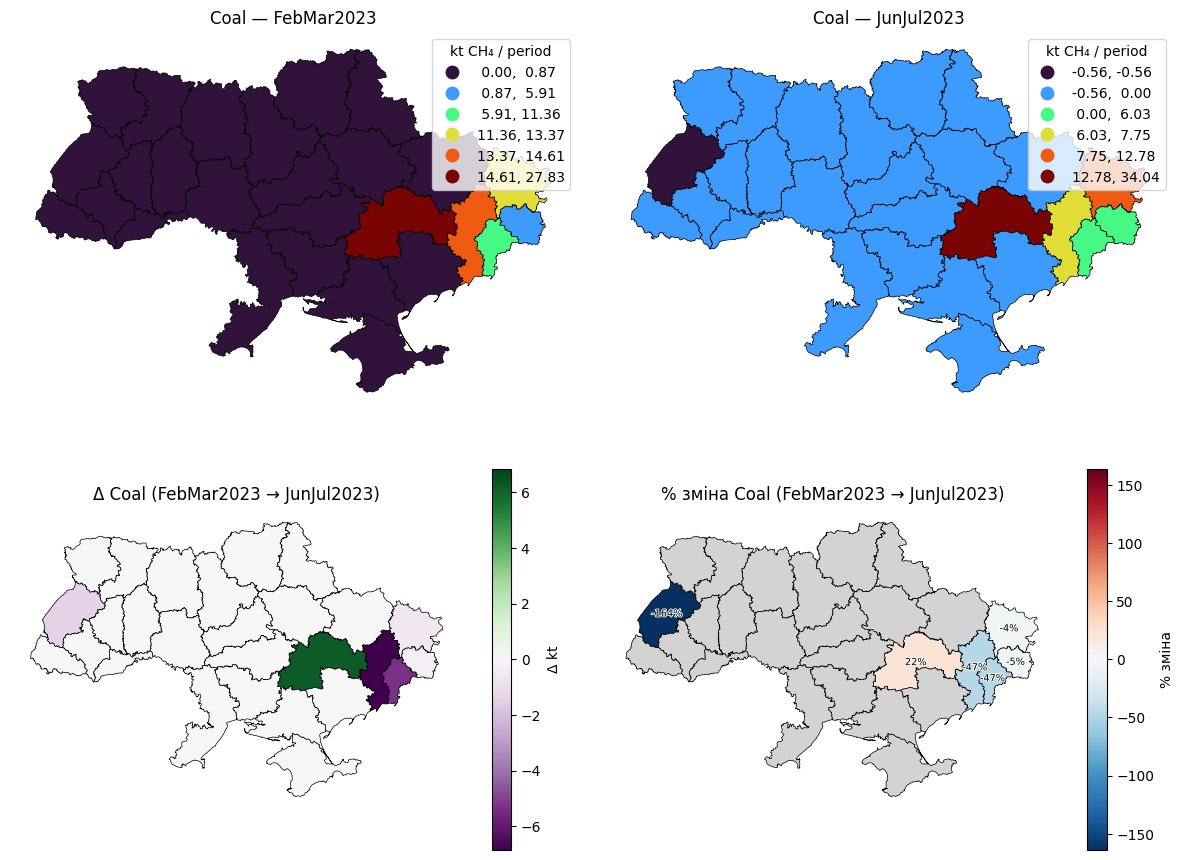

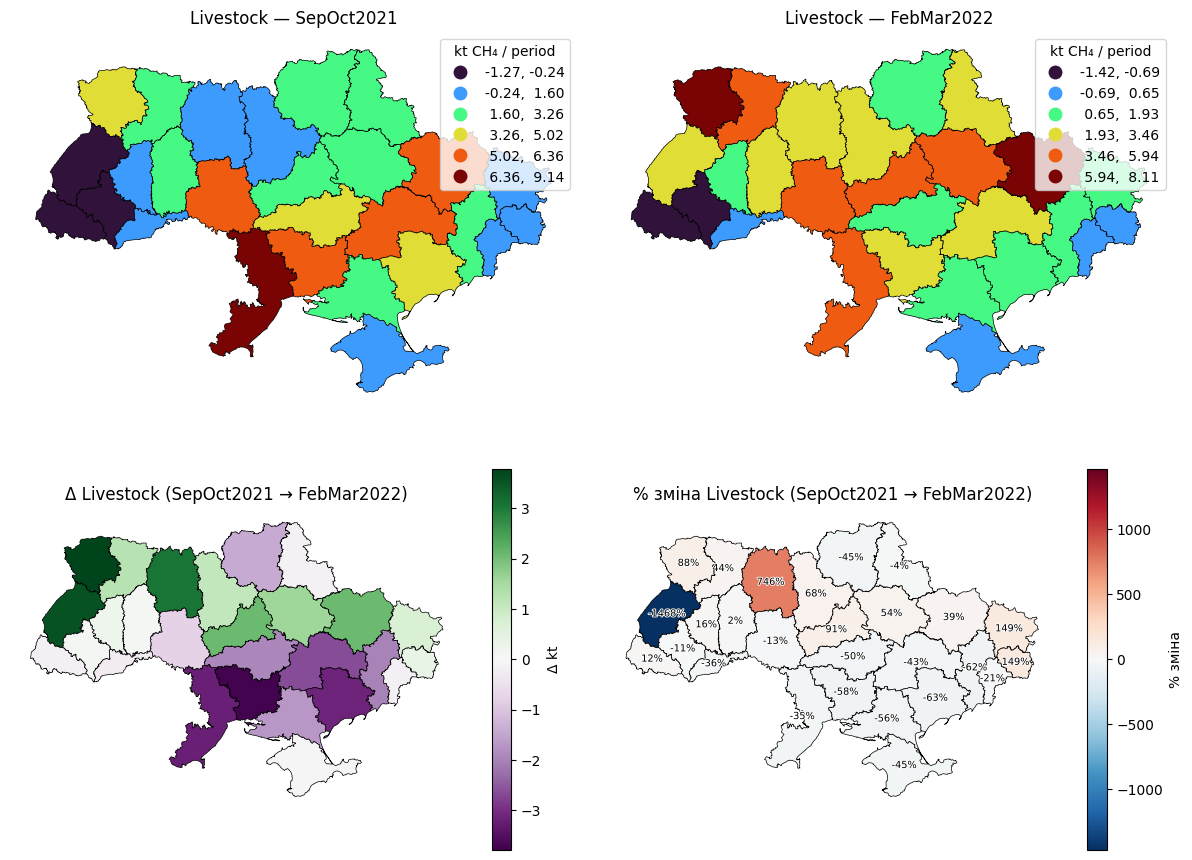

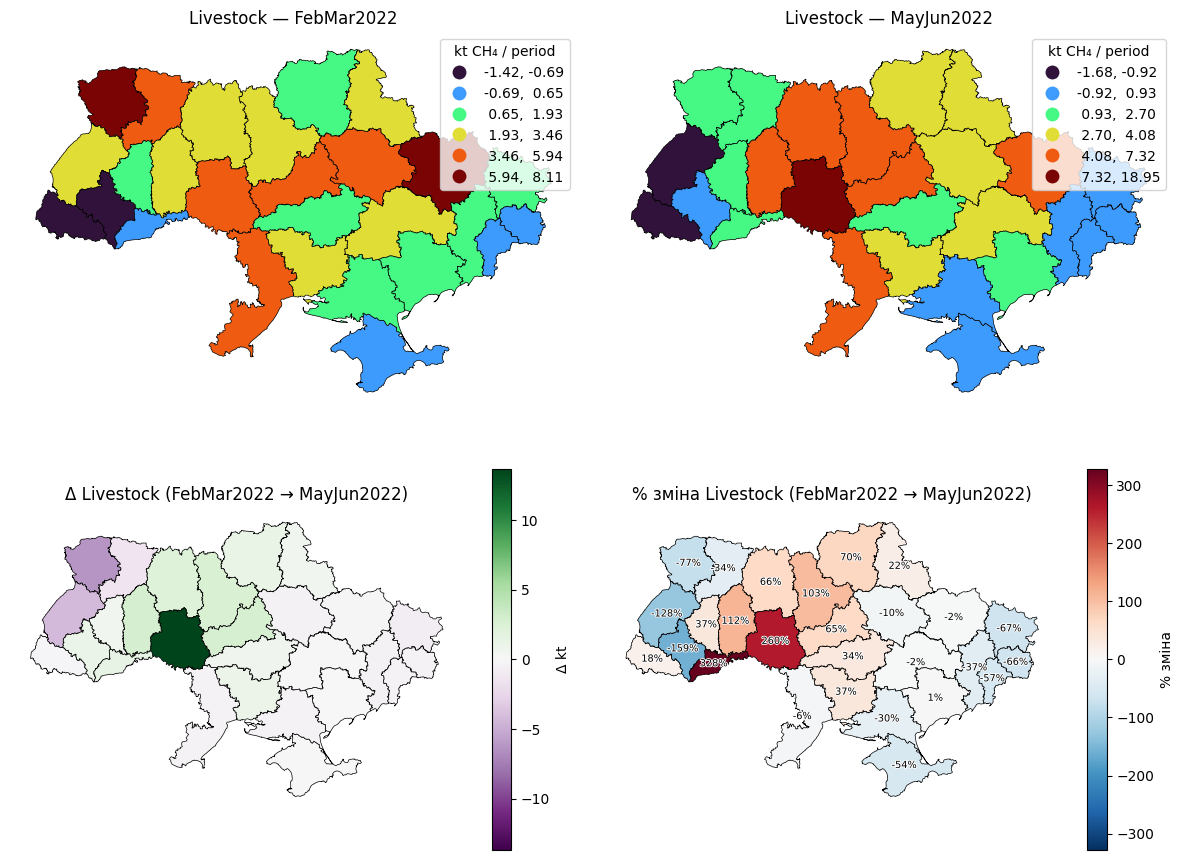

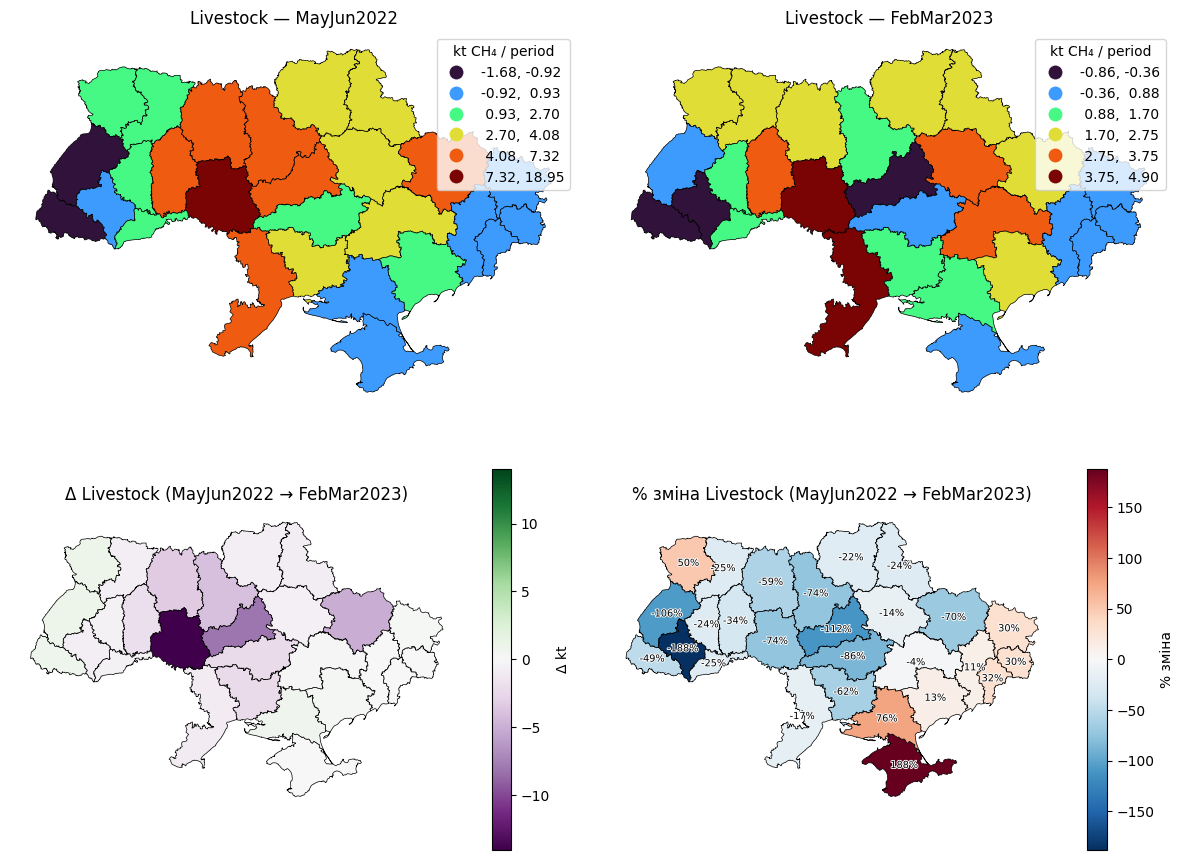

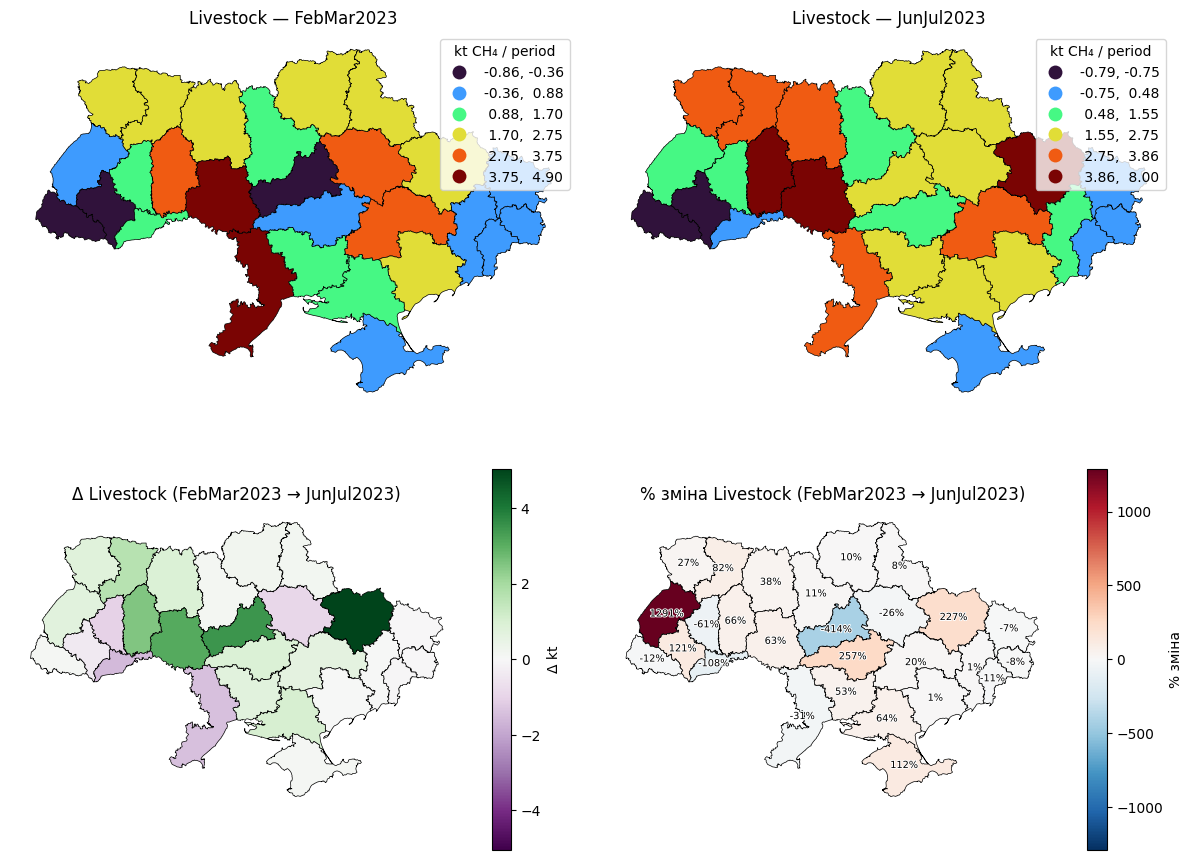

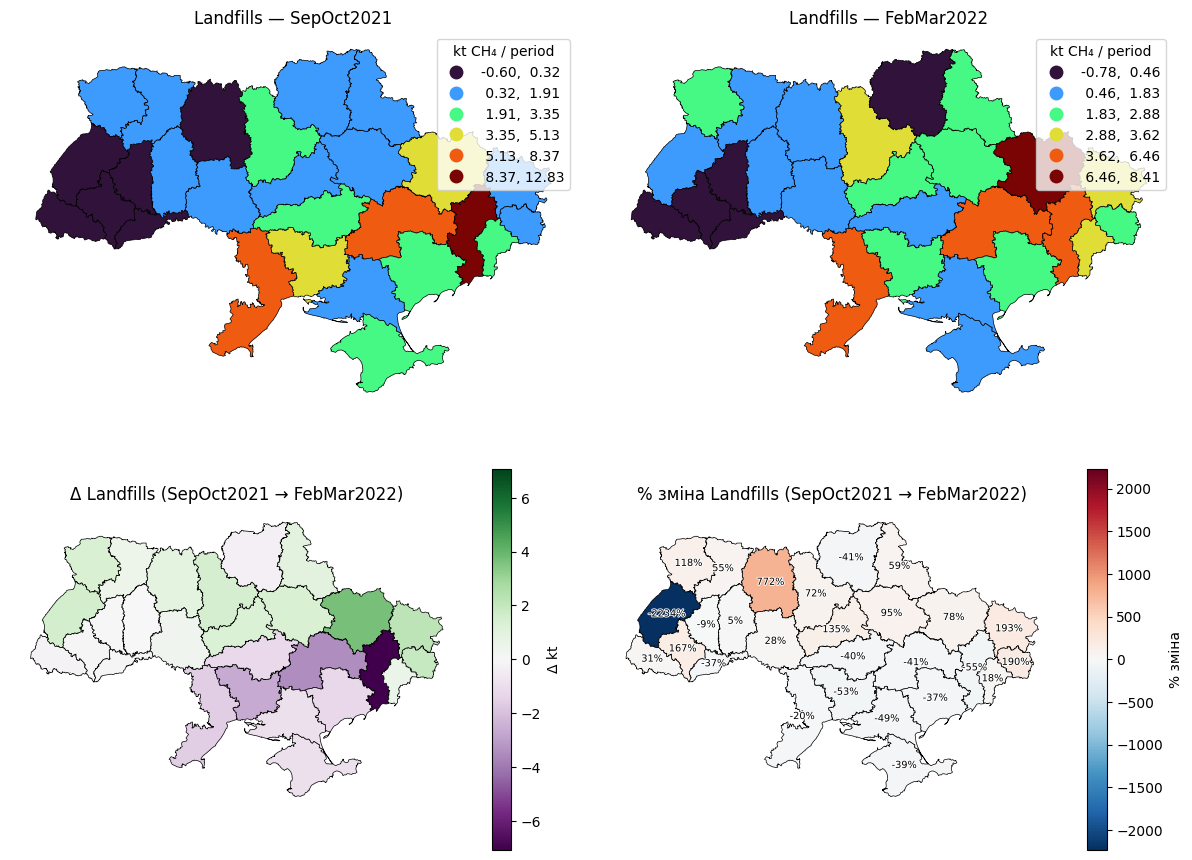

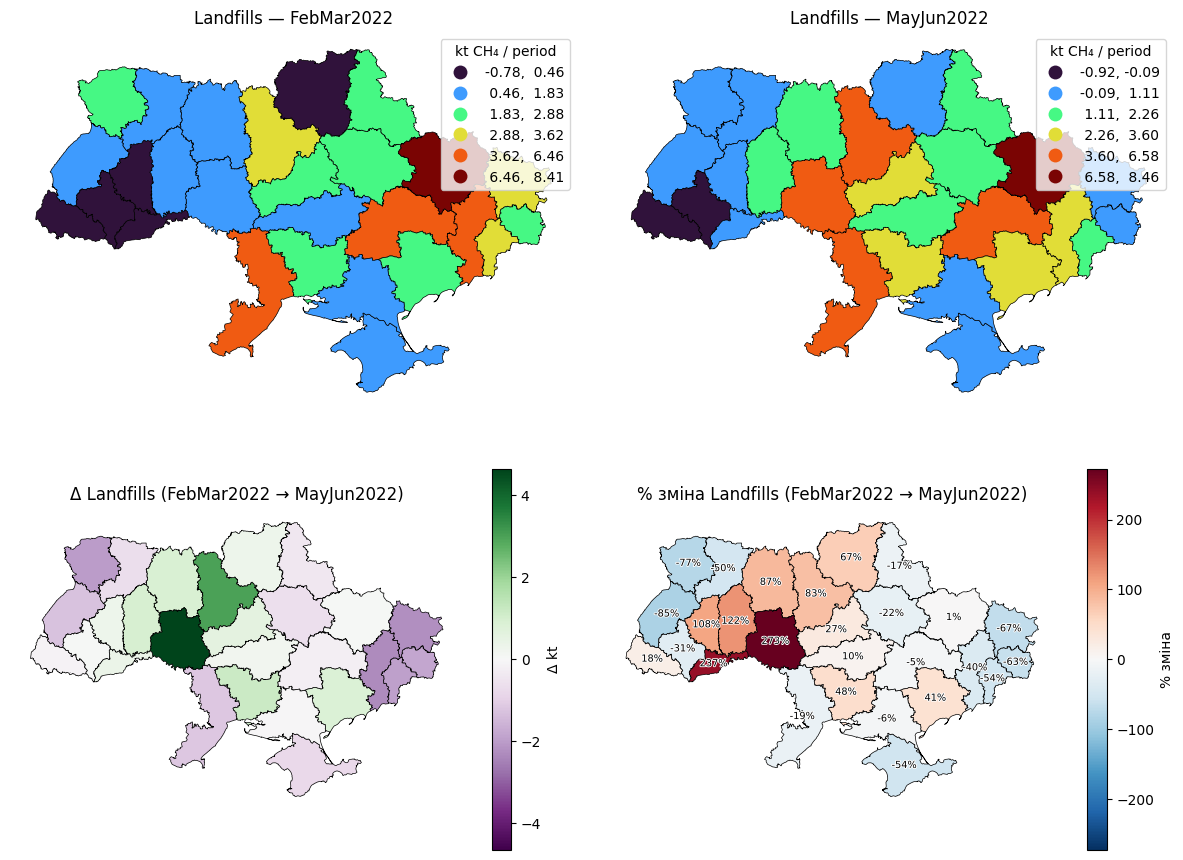

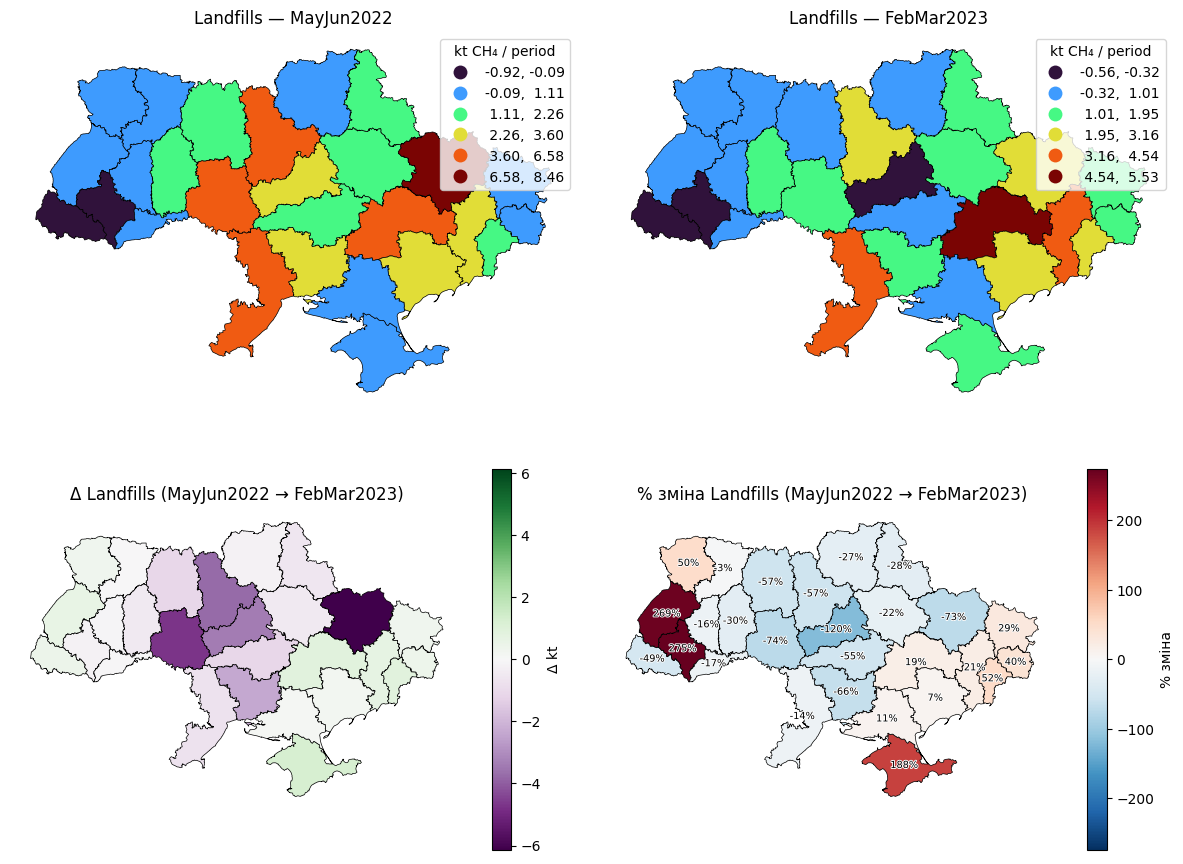

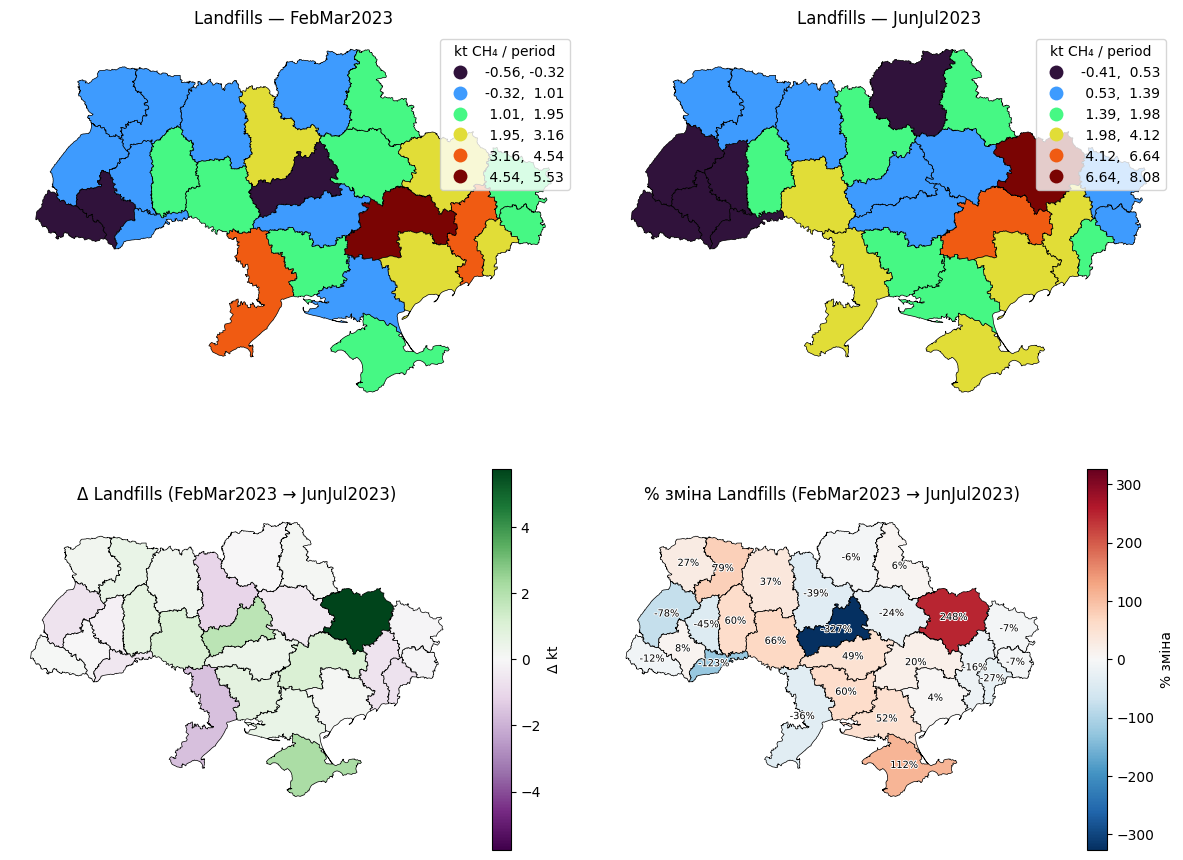

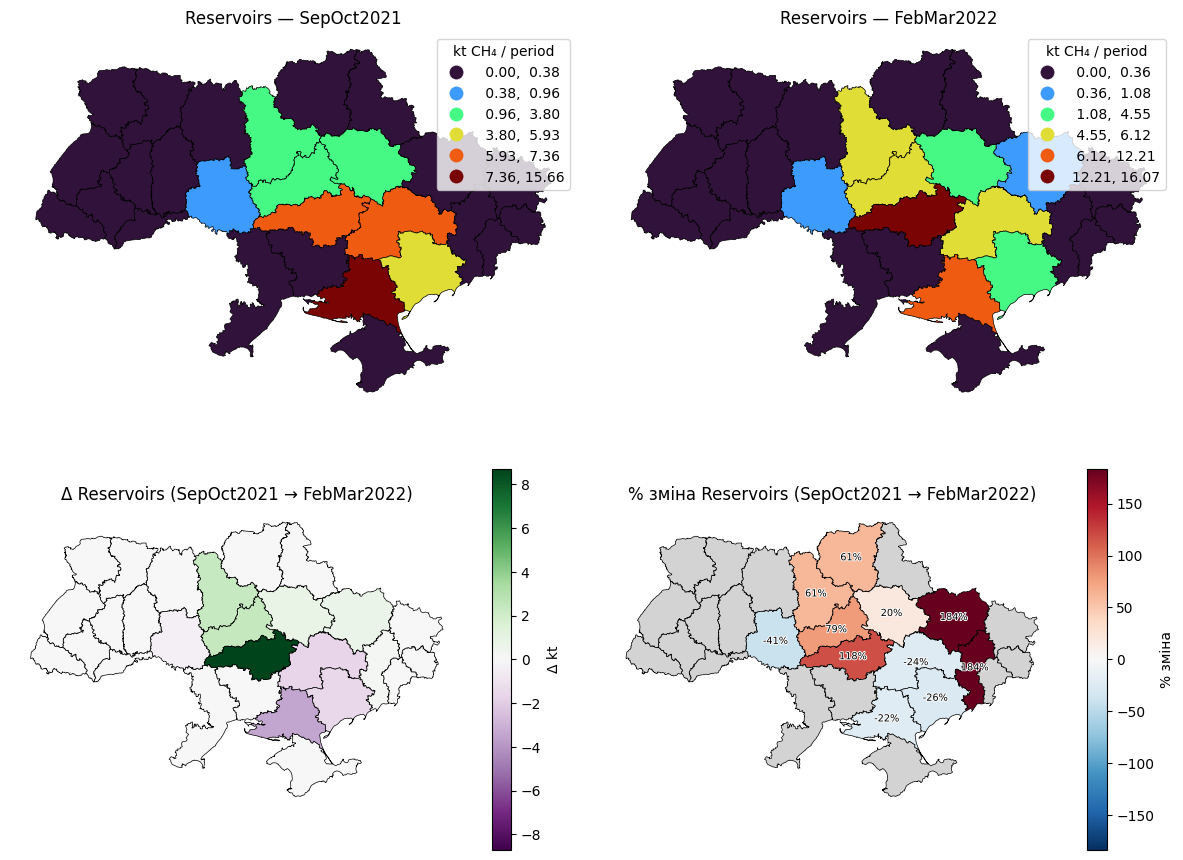

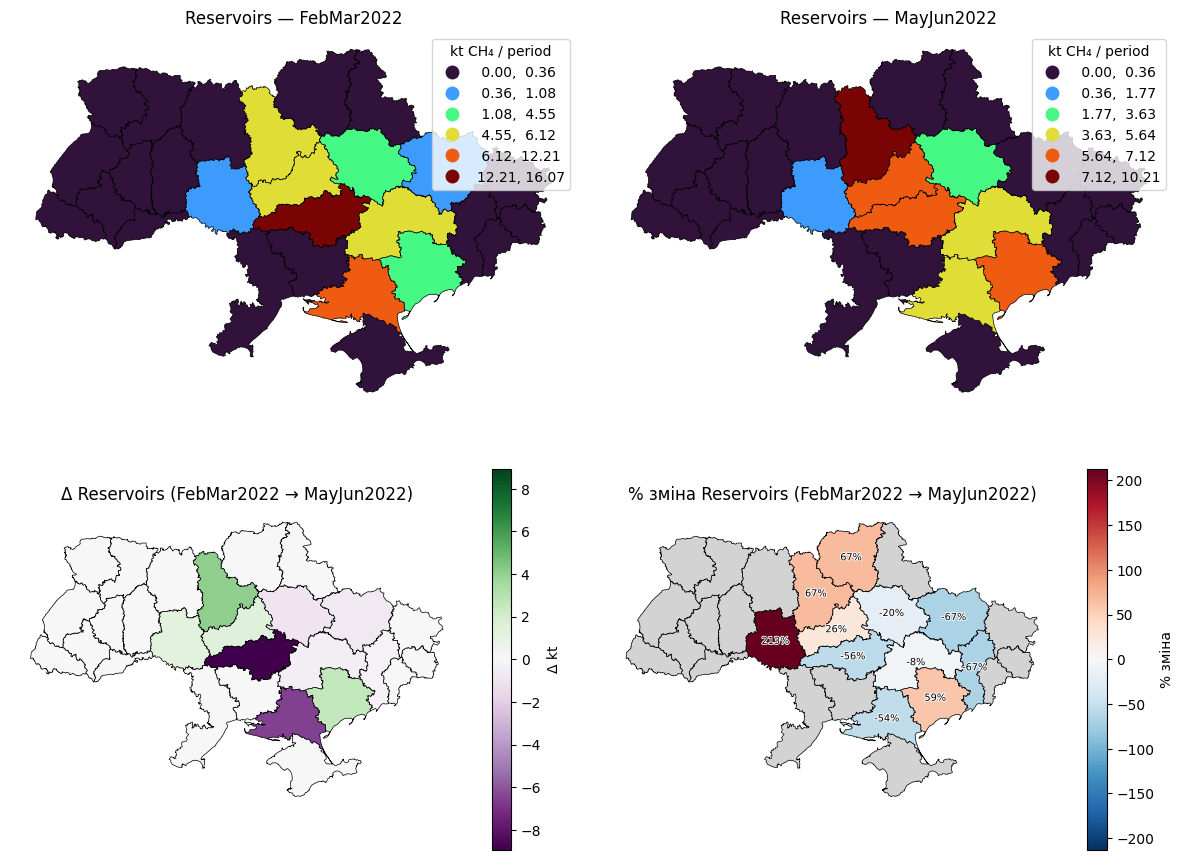

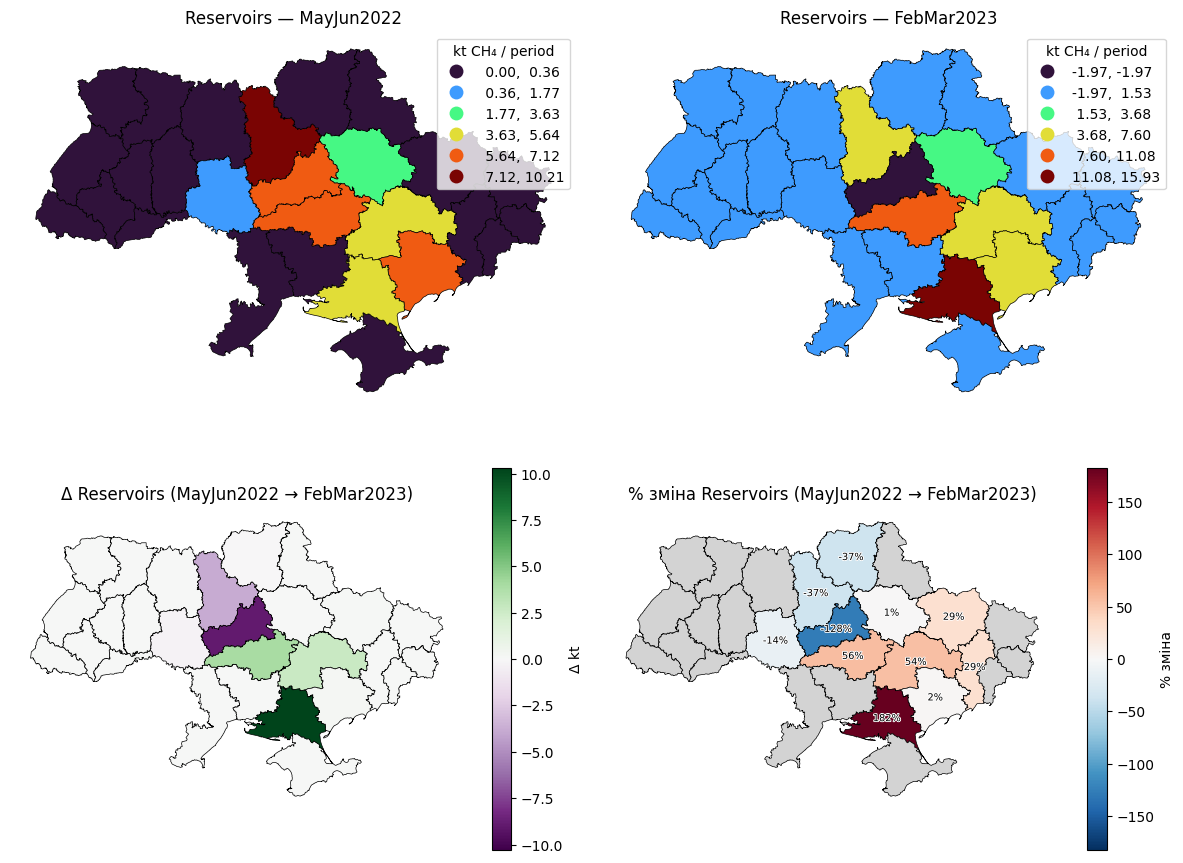

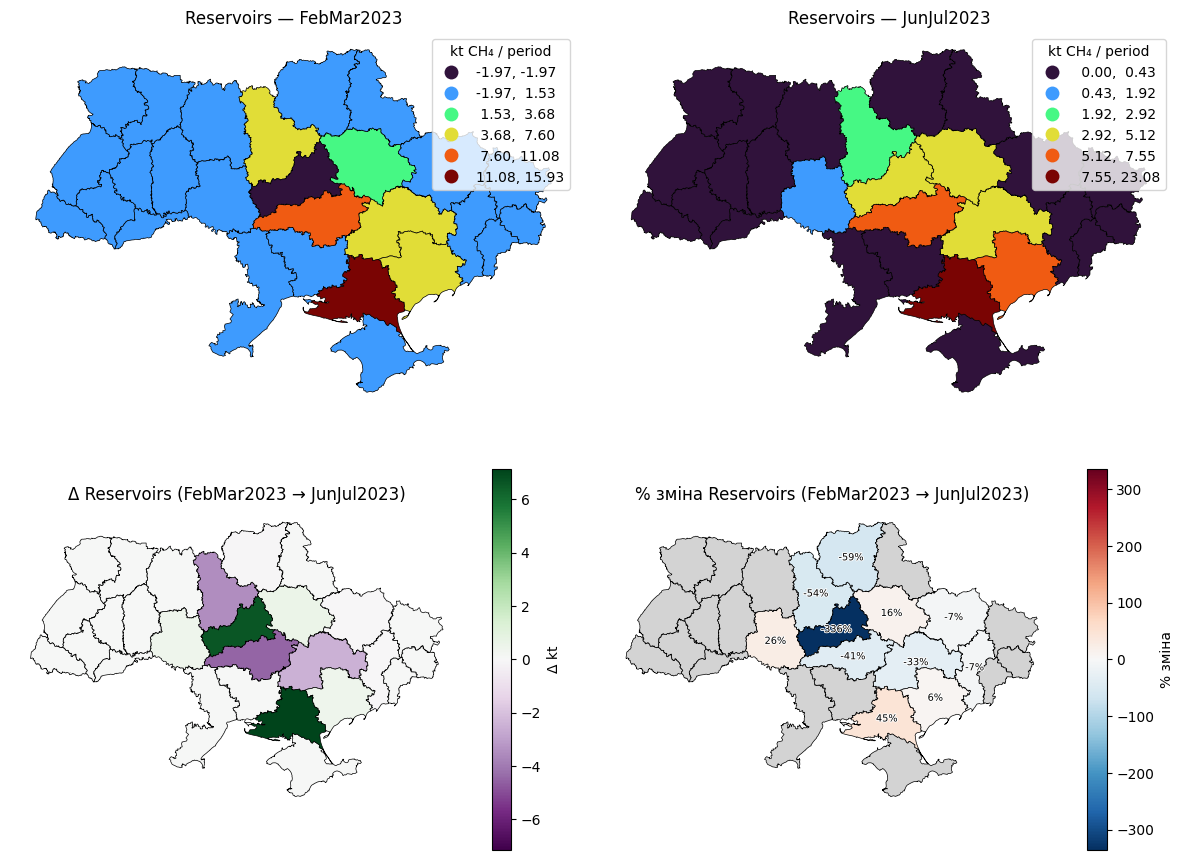

In [2]:
# ────────────────────── 4. main ───────────────────────────────────────────
if __name__ == "__main__":
    short = ["SepOct2021","FebMar2022","MayJun2022","FebMar2023","JunJul2023"]
    for sec in SECTORS:
        df_sec = build_df(sec)
        for old, new in zip(short[:-1], short[1:]):
            plot_3maps(df_sec, sec, old, new)